# Summary

Generating all the analysis I need for my final report.

### Descriptives

1. Show velocity converging to 0 for unhealthy repos vs. healthy repos
1. Provide general overview of the data
1. Speak to data processing
1. Speak to data cleaning
1. Speak to feature engineering

### Predictives

1. Correlation matrix with features (multicollinearity)
1. Show forecasting algorithm (linear regression)
1. Run and report several forecasts
1. Check for autocorrelation, plot residuals

# Dependencies

In [1]:
library(broom)
library(corrplot)
library(dplyr)
library(ggplot2)
library(glmnet)
library(lubridate)
library(readr)
library(stringr)

corrplot 0.84 loaded

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



# Load Data

In [2]:
rdir <- "~/code/rcompat/"
list.files(rdir)

[1] "authors_prototype.csv"    "commits_prototype.csv"   
[3] "df_features_20190424.csv" "df_target_20190424.csv"  
[5] "meta_prototype.csv"

In [3]:
authors_prototype <- read_csv(paste0(rdir, 'authors_prototype.csv'))
dim(authors_prototype)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  commit_hash = col_character(),
  name = col_character(),
  email = col_character(),
  authored = col_datetime(format = "")
)


[1] 928779      5

In [4]:
commits_prototype <- read_csv(paste0(rdir, 'commits_prototype.csv'))
dim(commits_prototype)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  file_id = col_integer(),
  commit_hash = col_character(),
  modified_file = col_character(),
  lines_added = col_integer(),
  lines_subtracted = col_integer()
)


[1] 2327964       6

In [5]:
meta_prototype <- read_csv(paste0(rdir, 'meta_prototype.csv'))
dim(meta_prototype)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  commit_hash = col_character(),
  owner_name = col_character(),
  project_name = col_character()
)


[1] 928779      4

In [6]:
df_target <- read_csv(paste0(rdir, 'df_target_20190424.csv'))
dim(df_target)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  ts = col_integer(),
  owner_name = col_character(),
  project_name = col_character(),
  lines_added = col_integer(),
  lines_deleted = col_integer(),
  velocity = col_integer()
)


[1] 14650     7

In [7]:
df_features <- read_csv(paste0(rdir, 'df_features_20190424.csv'))
dim(df_features)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  index = col_integer(),
  ts = col_integer(),
  owner_name = col_character(),
  project_name = col_character(),
  num_authors = col_integer(),
  org_name = col_integer(),
  mentor_count = col_double()
)


[1] 14650     8

# Data Preprocessing

We need to create a working table for the prototype data.

In [8]:
# one to one join

df <- meta_prototype %>% select(-X1) %>%
    inner_join(authors_prototype %>% select(-X1), by=c('commit_hash' = 'commit_hash'))


dim(df)

[1] 928779      6

In [9]:
# one to many join where meta_info without commits info is removed with right_join

df <- df %>%  
        right_join(commits_prototype %>% select(-X1), 
                   by=c('commit_hash' = 'commit_hash'))

dim(df)[1] == dim(commits_prototype)[1] # check dimensions

[1] TRUE

# Descriptives

Generate descriptive stats and figures for report and presentation.

## Provide general overview of the data

In [10]:
projects <- df_features %>% select(owner_name, project_name) %>% unique()

In [11]:
# 2019-04-24 14:11:45,170 INFO Completed 2869 successes, 58 failures

projects %>% count()

n
2869


Saving 7 x 7 in image


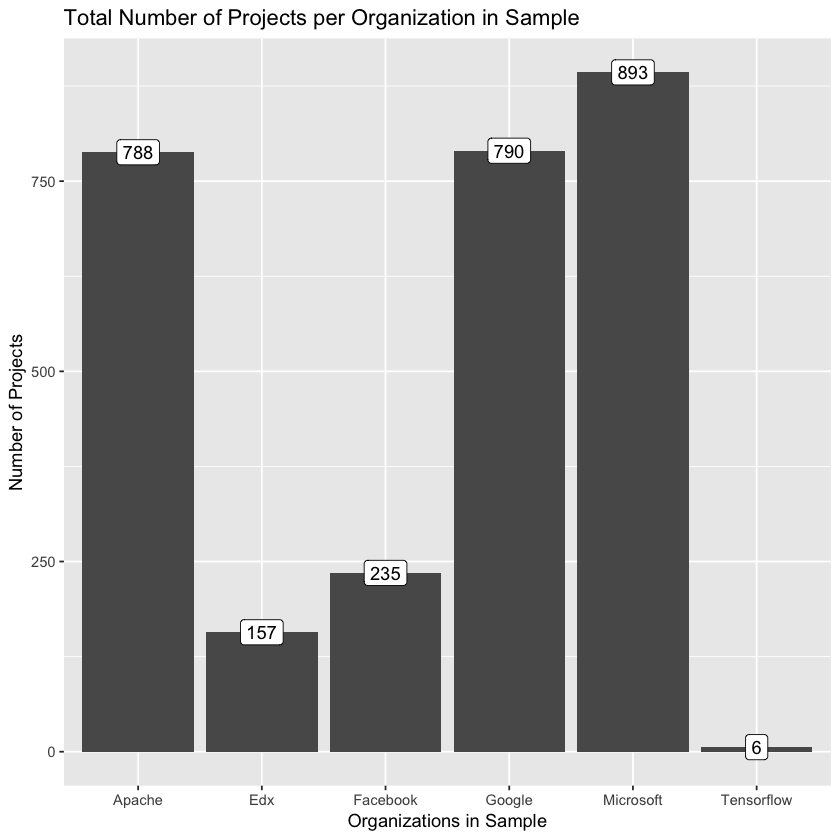

In [12]:
# Projects by organization

orgs <- projects %>% group_by(owner_name) %>% count() %>% 
            ungroup() %>%
            mutate(owner_name = str_to_title(owner_name))
f1 <- ggplot(orgs, aes(owner_name, n)) + geom_col() + 
        geom_label(aes(label=n)) +
        labs(title='Total Number of Projects per Organization in Sample',
             y='Number of Projects',
             x='Organizations in Sample')
ggsave('imgs/f1.png')
f1

### Show velocity by organization $\downarrow$

In [13]:
minimal_projs <- df_target %>% filter(ts == 2018) %>% mutate(minimal =  velocity > -100 & velocity <= 100)
dim(minimal_projs)

[1] 1515    8

In [14]:
all_projs <- df_target %>% select(owner_name, project_name) %>% unique()
dim(all_projs)

[1] 2869    2

In [15]:
full_list <- minimal_projs %>% 
                select(-X1) %>% 
                full_join(all_projs, 
                          by=c("owner_name" = "owner_name", "project_name" = "project_name"))

dim(full_list)[1] == dim(all_projs)[1]

[1] TRUE

In [16]:
summary(full_list$minimal)

   Mode   FALSE    TRUE    NA's 
logical    1095     420    1354 

In [17]:
# Get all projects in 2018 irrespective of commits present

full_imp_list <- full_list %>%
                mutate(
                    ts = ifelse(is.na(ts), 2018, ts),
                    minimal = ifelse(is.na(minimal), TRUE, minimal),
                    lines_added = ifelse(is.na(lines_added), 0, lines_added),
                    lines_deleted = ifelse(is.na(lines_deleted), 0, lines_deleted),
                    velocity = ifelse(is.na(velocity), 0, velocity)
                )
summary(full_imp_list$minimal)

   Mode   FALSE    TRUE 
logical    1095    1774 

In [18]:
orgmove <- full_imp_list %>% 
            group_by(owner_name) %>% 
            summarize(n = n(), dead = sum(minimal)) %>%
            ungroup() %>%
            mutate(fdead = cut(dead/n * 100, breaks=4),
                  owner_name = str_to_title(owner_name))

head(orgmove)

owner_name,n,dead,fdead
Apache,788,423,"(43.7,57.2]"
Edx,157,109,"(57.2,70.8]"
Facebook,235,146,"(57.2,70.8]"
Google,790,559,"(57.2,70.8]"
Microsoft,893,536,"(57.2,70.8]"
Tensorflow,6,1,"(16.6,30.2]"


Saving 7 x 7 in image


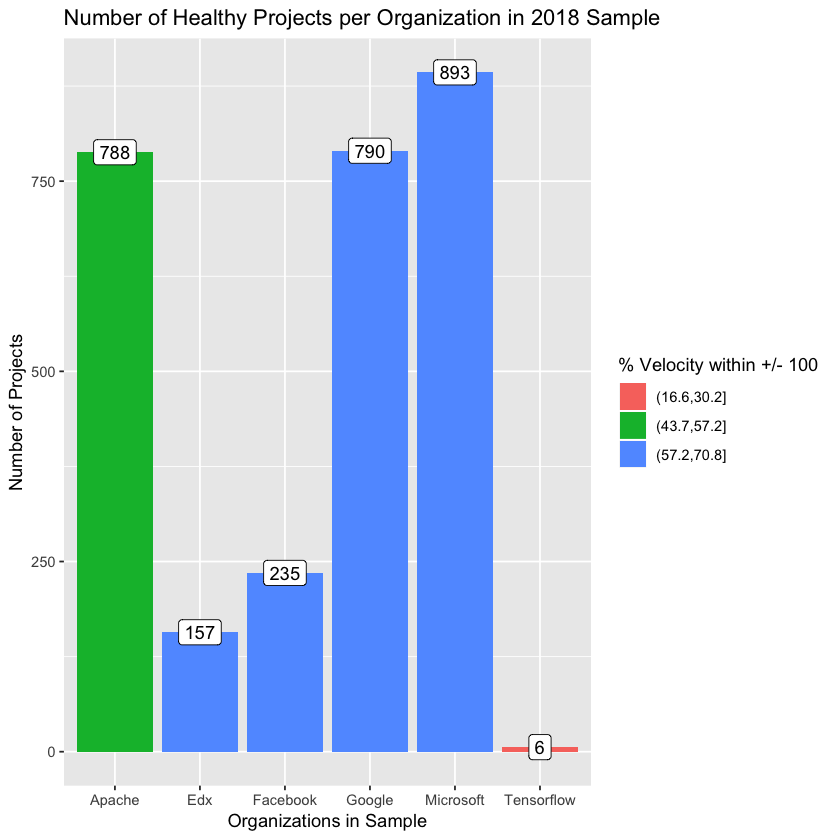

In [19]:
f2 <- ggplot(orgmove, aes(owner_name, n, fill=fdead)) + geom_col() + 
        geom_label(aes(label=n), fill='white') +
        labs(title='Number of Healthy Projects per Organization in 2018 Sample',
             y='Number of Projects',
             x='Organizations in Sample',
             fill='% Velocity within +/- 100')
ggsave('imgs/f2.png')
f2

Figure 2 seems like a nice idea but too much information for the audience initially.
Let's show something similar at the end once we've established some metrics. This
should actually go at the end.

## Show velocity converging to 0 for unhealthy repos vs. healthy repos

I established baseline behavior by reviewing well known and Apache open 
source projects to see if I could find any patterns.

In [20]:
# Compute velocity

dim(df)[1] == dim(commits_prototype)[1]
df <- df %>% mutate(velocity = lines_added - lines_subtracted,
                    year = year(as_datetime(authored)))

[1] TRUE

In [21]:
# Group by year, project_name, owner_name

velocity_by_year <- df %>% 
                        mutate(project_id = str_c(owner_name, "-", project_name)) %>%
                        filter(year >= 2013 & year < 2019) %>%
                        group_by(year, project_id) %>%
                        summarize(total_velocity = sum(velocity, na.rm=TRUE))

Saving 7 x 7 in image


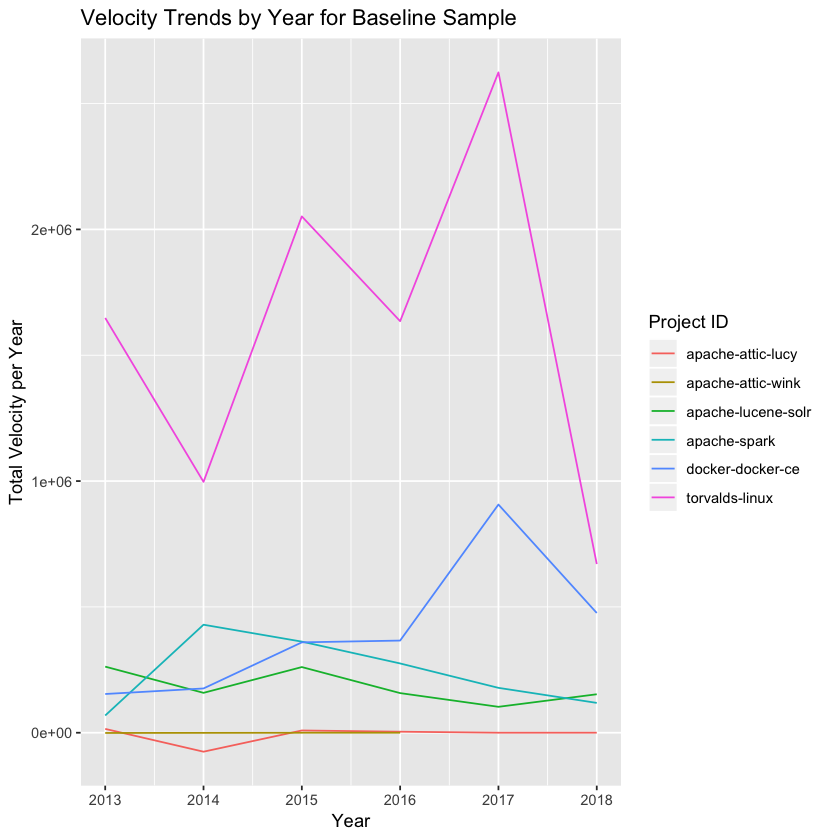

In [22]:
f3 <- ggplot(velocity_by_year, aes(year, total_velocity)) + 
            geom_line(aes(group=project_id, color=project_id)) +
            labs(
                title = "Velocity Trends by Year for Baseline Sample",
                y = "Total Velocity per Year",
                x = "Year",
                color = "Project ID"
            )
ggsave('imgs/f3.png')
f3

We can see a clear trend here where the two Apache projects in the "attic", Lucy and Wink,
have a velocity which converges near zero by 2015.

# Predictives

Redo previous forecasting for baseline in R. Look to see if 
Forecast model generalizes for larger sample.

In [23]:
head(df_target)
dim(df_target)

X1,ts,owner_name,project_name,lines_added,lines_deleted,velocity
0,2015,apache,cordova-plugin-legacy-whitelist,940,94,846
1,2016,apache,cordova-plugin-legacy-whitelist,38,5,33
2,2017,apache,cordova-plugin-legacy-whitelist,5,1,4
3,2019,apache,cordova-plugin-legacy-whitelist,168,7,161
0,2014,apache,couchdb-setup,924,67,857
1,2015,apache,couchdb-setup,283,74,209


[1] 14650     7

In [24]:
head(df_features)
dim(df_features)

X1,index,ts,owner_name,project_name,num_authors,org_name,mentor_count
0,0,2014,apache,couchdb-setup,40,0,NA
1,1,2015,apache,couchdb-setup,30,0,NA
2,2,2016,apache,couchdb-setup,7,0,NA
3,3,2017,apache,couchdb-setup,15,0,NA
0,0,2011,apache,ant-easyant-tasks,131,0,NA
1,1,2012,apache,ant-easyant-tasks,28,0,NA


[1] 14650     8

### Data Preprocessing

Just replace NA values with 0

In [25]:
X <- df_features %>% select(-X1, -index) %>%
        filter(ts > 2012 & ts <= 2018) %>%
        mutate(
            num_authors = ifelse(is.na(num_authors), 0, num_authors),
            org_name = ifelse(is.na(org_name), 0, org_name),
            mentor_count = ifelse(is.na(mentor_count), 0, mentor_count)
        )
dim(X)

[1] 9705    6

In [26]:
y <- df_target %>% select(-X1) %>%
        filter(ts > 2012 & ts <= 2018) %>%
        mutate(
            velocity = ifelse(is.na(velocity), 0, velocity)
        )
dim(y)

[1] 9705    6

## Checking for correlation between features

The prototype had really highly correlated features, let's
see if that still holds when we scale up.


In [27]:
M <- X %>% select(-ts, -owner_name, -project_name) %>% cor()
M

,num_authors,org_name,mentor_count
num_authors,1.0000000,0.14398955,0.71299974
org_name,0.1439896,1.00000000,0.03773572
mentor_count,0.7129997,0.03773572,1.00000000


We're finding a much lower correlation after scaling up. Let's
continue trying to replicate the prototype.

### Train/test/val sets

In [28]:
X_train <- X %>% filter(ts == 2015) %>% select(num_authors, org_name, mentor_count)
y_train <- y %>% filter(ts == 2015) %>% select(velocity)

dim(X_train)[1] == dim(y_train)[1]

[1] TRUE

In [29]:
X_test <- X %>% filter(ts == 2016) %>% select(num_authors, org_name, mentor_count)
y_test <- y %>% filter(ts == 2016) %>% select(velocity)

dim(X_test)[1] == dim(y_test)[1]

[1] TRUE

In [30]:
X_val <- X %>% filter(ts == 2017) %>% select(num_authors, org_name, mentor_count)
y_val <- y %>% filter(ts == 2017) %>% select(velocity)

dim(X_val)[1] == dim(y_val)[1]

[1] TRUE

### Fit training set

In [31]:
m1 <- lm(y_train$velocity ~ X_train$num_authors + X_train$org_name + X_train$mentor_count)
summary(m1)


Call:
lm(formula = y_train$velocity ~ X_train$num_authors + X_train$org_name + 
    X_train$mentor_count)

Residuals:
     Min       1Q   Median       3Q      Max 
-2236733   -36094   -34641   -30291 17765463 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          34629.818  13426.139   2.579  0.00998 ** 
X_train$num_authors     15.125      2.074   7.294 4.43e-13 ***
X_train$org_name       -25.845    304.090  -0.085  0.93228    
X_train$mentor_count  -681.250    756.226  -0.901  0.36778    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 558800 on 1872 degrees of freedom
Multiple R-squared:  0.04255,	Adjusted R-squared:  0.04101 
F-statistic: 27.73 on 3 and 1872 DF,  p-value: < 2.2e-16


Saving 7 x 7 in image


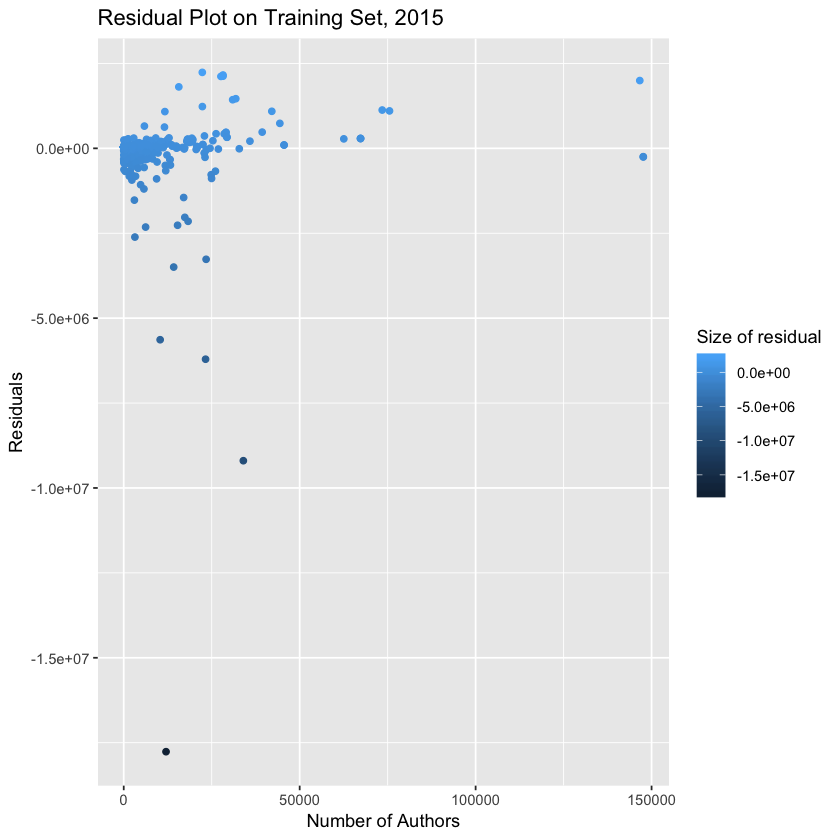

In [32]:
# Plot residuals

y_pred_train <- predict(m1, X_train)
residuals_train <- tibble(y_pred_train - y_train$velocity)
colnames(residuals_train) <- c("y_resid")

f4 <- ggplot(residuals_train, aes(X_train$num_authors, y_resid, color=y_resid)) + 
        geom_point() + 
        labs(
            title = "Residual Plot on Training Set, 2015",
            x = "Number of Authors",
            y = "Residuals",
            color = "Size of residual"
        )
ggsave('imgs/f4.png')
f4

Scaling the model up provides really different results than the prototype.
Let's use a model which is more robust from outliers. We can see that certain
residuals are very far from 0, most residuals are clustered around residuals.
So we need to penalize outliers.

### Ridge Regression

In [33]:
X_train <- X_train %>% data.matrix()
lambdas <- 10^seq(10, -2, by = -.1)

In [34]:
cv_fit <- cv.glmnet(X_train, y_train$velocity, alpha = 0, lambda = lambdas)

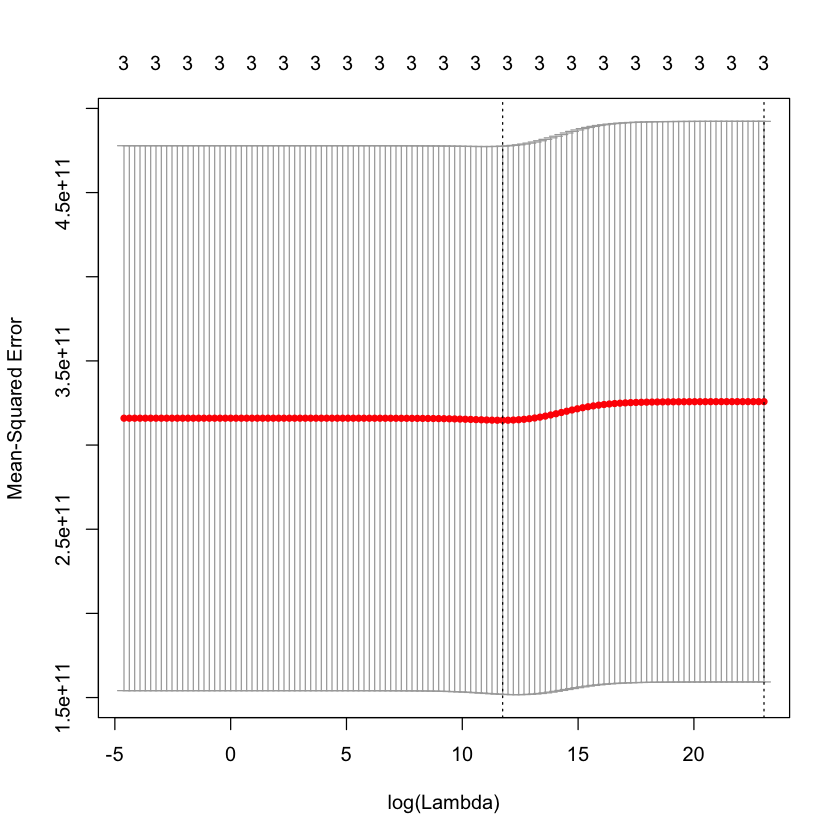

In [35]:
plot(cv_fit)

In [36]:
# Fitted vals from cross-validation

opt_lambda <- cv_fit$lambda.min
fit <- cv_fit$glmnet.fit


In [37]:
X_test <- X_test %>% data.matrix()
y_pred_test <- c(predict(fit, s = opt_lambda, newx = X_test))

Saving 7 x 7 in image


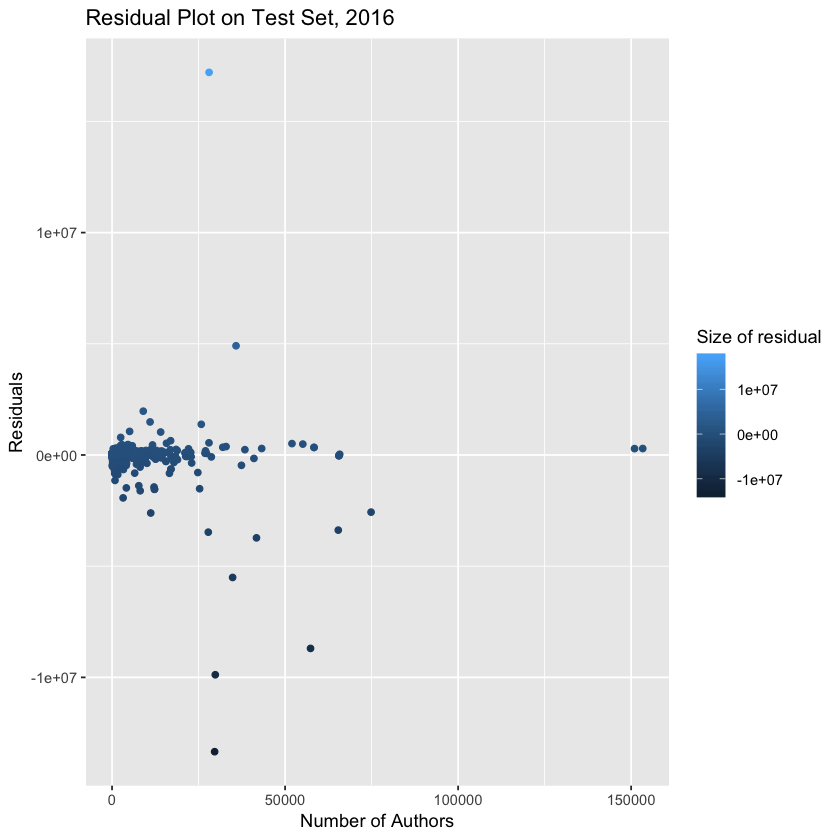

In [38]:
residuals_train <- tibble(y_pred_test - y_test$velocity)
colnames(residuals_train) <- c("y_resid")

f5 <- ggplot(residuals_train, aes(X_test[,1], y_resid, color=y_resid)) + 
        geom_point() + 
        labs(
            title = "Residual Plot on Test Set, 2016",
            x = "Number of Authors",
            y = "Residuals",
            color = "Size of residual"
        )
ggsave('imgs/f5.png')
f5

### Predicting with the validation set

In [39]:
X_val <- X_val %>% data.matrix()
y_pred_val <- c(predict(fit, s = opt_lambda, newx = X_val))

Saving 7 x 7 in image


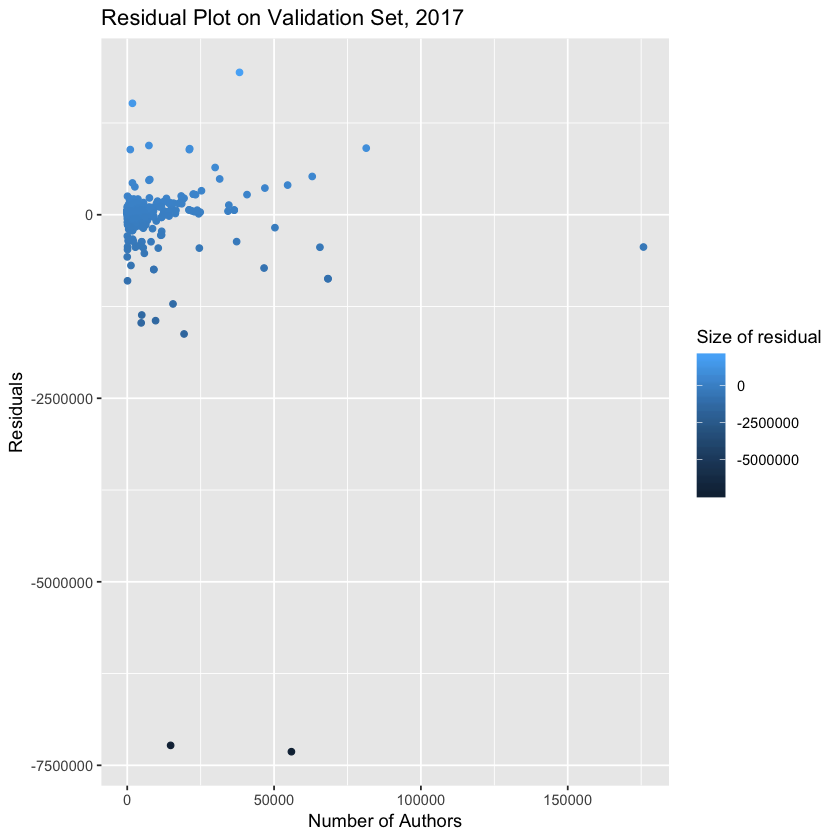

In [40]:
residuals_train <- tibble(y_pred_val - y_val$velocity)
colnames(residuals_train) <- c("y_resid")

f6 <- ggplot(residuals_train, aes(X_val[,1], y_resid, color=y_resid)) + 
        geom_point() + 
        labs(
            title = "Residual Plot on Validation Set, 2017",
            x = "Number of Authors",
            y = "Residuals",
            color = "Size of residual"
        )
ggsave('imgs/f6.png')
f6

Let's clean this notebook up a bit then put together the presentation and write up.